In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import pathlib
import pickle #to save files

%matplotlib inline

In [2]:
#---------------------------------------------------------------------------------------------------------
# Set path to folder containing Subject ID numbers
path = '/Volumes/RT&O/CIS-PD Study/Subjects/' #Mac
# path = r'C:\Users\andre\Documents\PD Study Data\RawData'
#---------------------------------------------------------------------------------------------------------

newDataFlag = 0
# newData is a flag for whether previously exported .csv data needs to be corrected and, if so, re-exports and overwrites
# old .csv data. Default is 0, which will only write new .csv files which previously did not exist

complete = list(['Heart Rate Variability', 'MDS-UPDRS #1: Finger Tapping',
           'MDS-UPDRS #2: Hand Movements', 'MDS-UPDRS #3: Pronation-Supination',
           'MDS-UPDRS #4: Toe Tapping', 'MDS-UPDRS #5: Leg Agility',
           'MDS-UPDRS #6: Arising from Chair', 'MDS-UPDRS #7: Gait',
           'MDS-UPDRS #8: Postural Stability', 'MDS-UPDRS #9: Postural Hand Tremor',
           'MDS-UPDRS #10: Kinetic Hand Tremor', 'MDS-UPDRS #11: Rest Tremor',
           'Motor #1: Standing', 'Motor #2: Walking', 'Motor #3: Walking while Counting',
           'Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements',
           'Motor #6: Sit to Stand', 'Motor #7: Drawing on Paper',
           'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts',
           'Motor #10: Drinking Water', 'Motor #11: Organizing Folder',
           'Motor #12: Folding Towels', 'Motor #13: Sitting'])


def process_annotations(path):
#def process_annotations(path, SubID):
#---------------------------------------------------------------------------------------------------------
# Processes raw annotations file to extract start / end timestamps and remove unnecessary data
#
# Inputs:  path - filepath of the subject folder containing annotations.csv
#
# Outputs: df - dataframe containing list of activities and their start / end timestamps
#---------------------------------------------------------------------------------------------------------
    df = pd.read_csv(os.path.join(path, 'annotations.csv'))
    del df['Timestamp (ms)']
    del df['AnnotationId']
    del df['AuthorId']
    
    testInfo = df[df.EventType == 'Testing Day'].dropna(how='any', axis=0)
    testInfo['Start Timestamp (ms)'] = pd.to_datetime(testInfo['Start Timestamp (ms)'], unit='ms', utc=True).dt.tz_localize('UTC').dt.tz_convert('US/Central')
    del testInfo['Stop Timestamp (ms)']
    del testInfo['EventType']
    del df['Value']
    
    testInfo = testInfo.rename(columns = {'Value':'Day', 'Start Timestamp (ms)':'Date'}).reset_index(drop=True)
    testInfo['Date'] = testInfo['Date'].dt.date
    
    df = df[(df.EventType != 'Testing Day')]

    # RESIDUAL: Separation into Day 1 and Day 2 data, may re-include at later time
    #Day1 = testInfo.loc[testInfo['Day'] == 'DAY 1', 'Date']
    #Day2 = testInfo.loc[testInfo['Day'] == 'DAY 2', 'Date']

    #d1_df = process_activities(df[df['Start Timestamp (ms)'].dt.date.isin(Day1)].reset_index(drop=True)).set_index('EventType')
    #d2_df = process_activities(df[df['Start Timestamp (ms)'].dt.date.isin(Day2)].reset_index(drop=True)).set_index('EventType')
    
    sorter = set(df.EventType.unique().flatten())
    sorterIndex = dict(zip(sorter, range(len(sorter))))
        
    df['EventType_Rank'] = df['EventType'].map(sorterIndex)
    df['Cycle'] = df.groupby('EventType')['Start Timestamp (ms)'].rank(ascending=True).astype(int)
    del df['EventType_Rank']
    #df[df['EventType'].str.contains('MDS-UPDRS')] = df[df['EventType'].str.contains('MDS-UPDRS')].replace(to_replace={'Cycle': {2: 3}})
    df[df['EventType'].str.contains('Heart')] = df[df['EventType'].str.contains('Heart')].replace(to_replace={'Cycle': {1: 'NaN', 2: 'NaN', 3: 'NaN', 4: 'NaN'}})
    df = df.reset_index(drop=True).set_index('EventType')
    
    #df = fix_errors(df, testInfo, SubID, path)
    
    # return d1_df, d2_df, df
    return df, testInfo

In [58]:
def extract_data(SubID, path):
#---------------------------------------------------------------------------------------------------------
# For a given subject, extracts and separates accelerometer, gyroscope, and EMG/ECG data into trials and sensor per activity
#
# Inputs: SubID - string of numbers corresponding to the subject ID
#         path - system path to corresponding subject's raw data files
#
# Outputs: act_dict - dictionary of both MDS-UPDRS and Motor Assessment activities separated by trial, sensor location, and
#                     accelerometer + gyroscope or accelerometer + EMG/ECG data. Every key within this dictionary is a dictionary
#---------------------------------------------------------------------------------------------------------
    #timestamps = process_annotations(path, SubID)
    timestamps, testInfo = process_annotations(path)
    
    # Creates list of sensor locations from folders within subject's raw data directory
    locations = [locs for locs in os.listdir(path) if os.path.isdir(os.path.join(path, locs))]
    
    # Creates dictionary of empty dataframes to merge all accelerometer, gyroscope, and EMG/ECG data for each sensor
    accel = {locs: pd.DataFrame() for locs in locations}
    gyro = {locs: pd.DataFrame() for locs in locations}
    elec = {locs: pd.DataFrame() for locs in locations}
    
    # Finds and merges all accelerometer, gyroscope, and EMG/ECG data for each sensor, retains datetime information
    for root, dirs, files in os.walk(path, topdown=True):
        for filenames in files:
            if filenames.endswith('accel.csv'):
                p = pathlib.Path(os.path.join(root, filenames))
                location = str(p.relative_to(path)).split("/")[0]
                temp_df = pd.read_csv(p).set_index('Timestamp (ms)')
                print(location)
                accel[location] = accel[location].append(temp_df)

            elif filenames.endswith('gyro.csv'):
                p = pathlib.Path(os.path.join(root, filenames))
                location = str(p.relative_to(path)).split("/")[0]
                temp_df = pd.read_csv(p).set_index('Timestamp (ms)')
                gyro[location] = gyro[location].append(temp_df)

            elif filenames.endswith(('elec.csv', 'emg.csv', 'ecg.csv', 'ekg.csv')):
                p = pathlib.Path(os.path.join(root, filenames))
                location = str(p.relative_to(path)).split("/")[0]
                temp_df = pd.read_csv(p).set_index('Timestamp (ms)')
                elec[location] = elec[location].append(temp_df)
                
    # Complete dictionary of all activities
    act_dict = {acts: pd.DataFrame() for acts in complete}

    # Populate dictionary keys per activity with every iteration / trial
    for activities in complete:
        
        startTimestamp = timestamps.loc[activities, 'Start Timestamp (ms)'].values
        endTimestamp = timestamps.loc[activities, 'Stop Timestamp (ms)'].values

        # Create trial dictionary with each key containing all sensor data related with each activity's trial
        trial_dict = {trials: pd.DataFrame() for trials in range(0, len(startTimestamp))}

        # Populate trial directory keys
        for trials in range(0, len(startTimestamp)):

            startTime = startTimestamp[trials]
            endTime = endTimestamp[trials]

            # Create sensor location dictionary with each key corresponding to sensor locations
            sensor_dict = {locs: pd.DataFrame() for locs in locations}

            # Extract sensor data and populate sensor_dict with sensor data
            for location in locations:

                data = {'accel': pd.DataFrame(), 'gyro': pd.DataFrame(), 'elec': pd.DataFrame()}

                if not accel[location].empty:
                    accelData = accel[location]
                    data['accel'] = accelData[(accelData.index >= startTime) & (accelData.index <= endTime)]

                if not gyro[location].empty:
                    gyroData = gyro[location]
                    data['gyro'] = gyroData[(gyroData.index >= startTime) & (gyroData.index <= endTime)]

                if not elec[location].empty:
                    elecData = elec[location]
                    data['elec'] = elecData[(elecData.index >= startTime) & (elecData.index <= endTime)]

                sensor_dict[location] = data

            trial_dict[trials] = sensor_dict

        act_dict[activities] = trial_dict
    
    export_data(act_dict, path, SubID, newDataFlag)
    
    return act_dict, timestamps, testInfo



def export_data(act_data, path, SubID, newDataFlag):
#---------------------------------------------------------------------------------------------------------
# Exports accel, gyro, and ecg/emg data correlating with timestamped activities into .csv files into respective folders
#
# Inputs: act_data - dictionary of all activities per subject
#         path - directory path pointing to location of subject folder, generally handled by a higher-level for loop
#         SubID - subject ID to analyze, handled by extract_data function
#         newDataFlag - flag for whether to re-export existing data
#
# Outputs: .csv files of all data separated by activity, sensor location, and start and end timestamps
#---------------------------------------------------------------------------------------------------------
    for activities in act_data:
        
        for trials in act_data[activities]:

            for sensors in act_data[activities][trials]:

                for data in act_data[activities][trials][sensors]:
                    
                    df = act_data[activities][trials][sensors][data]

                    if not df.empty:
                        #filename = data + '_' + str(trials) + '.csv'
                        filename = data + '.csv'
                        act_name = activities.replace(':', ' -')
                        folder = os.path.join('TimeSplitData', SubID, act_name, 'Trial ' + str(trials+1), sensors)
                        
                        if not os.path.isdir(folder):
                            os.makedirs(folder)
                            
                        if newDataFlag:
                            df.to_csv(os.path.join(folder, filename))
                        else:
                            if not os.path.exists(os.path.join(folder, filename)):
                                df.to_csv(os.path.join(folder, filename))
                                
def plot_data(acts, activity, trial, sensor, data, start=0, end=1000):
#---------------------------------------------------------------------------------------------------------
# Plots requested data
# 
# Inputs: acts - activity dataframe containing all sensor data from one subject
#         activity - desired activity to plot
#         trial - desired trial number to plot
#         sensor - desired sensor (serial number or name of location) to analyze
#         data - desired type of data to analyze (accel, gyro, EMG/ECG)
#         start - starting index, default starts at first point
#         end - ending index, default is 500th data point
#---------------------------------------------------------------------------------------------------------
    toPlot = pd.DataFrame(acts[activity][trial]).loc[data, sensor][start:end].plot()

In [4]:
os.listdir(path+'/1020/anterior_thigh_left/d5la7wz0/')

['2017-08-03T17-44-51-148Z']

In [10]:
SubID = '1020'
act_dict, timestamps, testInfo = extract_data(SubID, os.path.join(path, SubID))

anterior_thigh_left
anterior_thigh_left
anterior_thigh_left
anterior_thigh_right
anterior_thigh_right
anterior_thigh_right
distal_lateral_shank_left
distal_lateral_shank_left
distal_lateral_shank_left
distal_lateral_shank_right
distal_lateral_shank_right
distal_lateral_shank_right
dorsal_hand_left
dorsal_hand_left
dorsal_hand_left
dorsal_hand_right
dorsal_hand_right
dorsal_hand_right
flexor_digitorum_left
flexor_digitorum_left
flexor_digitorum_left
flexor_digitorum_right
flexor_digitorum_right
flexor_digitorum_right
medial_chest
medial_chest
medial_chest
sacrum
sacrum
sacrum


In [40]:
#save dict to Pickle file
f = open('1020dict.pk1','wb')
pickle.dump(act_dict,f)
f.close()

In [3]:
#load Pickle file dict
f = open('../Data/1020dict.pk1','rb')
act_dict = pickle.load(f)
f.close()

In [4]:
len(act_dict['Motor #1: Standing'].keys())

6

In [5]:
act_dict['Motor #1: Standing'][1]['medial_chest']['accel'].head()

,Accel X (g),Accel Y (g),Accel Z (g)
Timestamp (ms),,,
1500580539584,0.047913,0.906813,0.380926
1500580539616,0.079164,0.886305,0.385809
1500580539649,0.077211,0.885328,0.380926
1500580539681,0.097230,0.918532,0.372625
1500580539713,0.071839,0.906325,0.377508


In [168]:
#EXAMPLE of creating dict of dicts
# trial = 0
# s  = 'accel'
# clip_data={}
# clip_data[trial] = {}
# clip_data[trial][s] = clips
# s2 = 'gyro'
# clip_data[trial][s2] = clips
# # clip_data[trial]['size'] = clip_len


In [52]:
rawdata = act_dict['Motor #1: Standing'][2]['medial_chest']['accel']

In [53]:
idx = rawdata.index
idx = idx-idx[0]
rawdata.index = idx
rawdata.head()

,Accel X (g),Accel Y (g),Accel Z (g)
Timestamp (ms),,,
0,0.073304,0.866285,0.361883
32,0.063050,0.892164,0.360418
65,0.087953,0.889723,0.339910
97,0.091371,0.941970,0.330144
129,0.100649,0.930251,0.338445


## Clip extraction

In [51]:
#extract clips for accelerometer and gyro data
def gen_clips(act_dict,task,location,clipsize=5000,overlap=0):
    
    clip_data = {} #the dictionary with clips
    #params
    len_tol = 0.8   #% of the intended clipsize below which clip is not used
    clipsize = 5000 #duration of clip in ms

    for trial in act_dict[task].keys():
        clip_data[trial] = {}            

        for s in ['accel','gyro']:

            print(task,' sensortype = %s - trial %d'%(s,trial))
            #create clips and store in a list
            rawdata = act_dict[task][trial][location][s]
            #reindex time (relative to start)
            idx = rawdata.index
            idx = idx-idx[0]
            rawdata.index = idx
            #create clips data
            deltat = np.median(np.diff(rawdata.index))
            idx = np.arange(0,rawdata.index[-1],clipsize*(1-overlap))
            clips = []
            for i in idx:
                c = rawdata[(rawdata.index>=i) & (rawdata.index<i+clipsize)]
                if len(c) > 0.8*int(clipsize/deltat): #discard clips whose length is less than len_tol% of the window size
                    clips.append(c)
            clip_len = [clips[c].index[-1]-clips[c].index[0] for c in range(len(clips))] #store the length of each clip
            #assemble in dict
            clip_data[trial][s] = {'data':clips, 'clip_len':clip_len}

    return clip_data


In [52]:
clip_data = gen_clips(act_dict,task='Motor #1: Standing',location='anterior_thigh_left',overlap=0)

Motor #1: Standing  sensortype = accel - trial 0
Motor #1: Standing  sensortype = gyro - trial 0
Motor #1: Standing  sensortype = accel - trial 1
Motor #1: Standing  sensortype = gyro - trial 1
Motor #1: Standing  sensortype = accel - trial 2
Motor #1: Standing  sensortype = gyro - trial 2
Motor #1: Standing  sensortype = accel - trial 3
Motor #1: Standing  sensortype = gyro - trial 3
Motor #1: Standing  sensortype = accel - trial 4
Motor #1: Standing  sensortype = gyro - trial 4
Motor #1: Standing  sensortype = accel - trial 5
Motor #1: Standing  sensortype = gyro - trial 5


In [53]:
clip_data[1]['accel']['clip_len']

[4995, 4979, 4978, 4995, 4979, 4979, 4434]

## Feature extraction

Let's start with the following:
* Energy (total within segment)
* Max
* Min
* Mean
* Variance
* Skewness
* Kurtosis
* FFT

# Visualize different tasks

In [22]:
act_dict.keys()

dict_keys(['MDS-UPDRS #6: Arising from Chair', 'Motor #2: Walking', 'Motor #6: Sit to Stand', 'MDS-UPDRS #11: Rest Tremor', 'Motor #3: Walking while Counting', 'Heart Rate Variability', 'MDS-UPDRS #3: Pronation-Supination', 'Motor #5: Alternating Hand Movements', 'MDS-UPDRS #7: Gait', 'Motor #10: Drinking Water', 'Motor #11: Organizing Folder', 'Motor #12: Folding Towels', 'MDS-UPDRS #2: Hand Movements', 'MDS-UPDRS #4: Toe Tapping', 'Motor #13: Sitting', 'MDS-UPDRS #5: Leg Agility', 'Motor #9: Nuts and Bolts', 'MDS-UPDRS #8: Postural Stability', 'Motor #1: Standing', 'MDS-UPDRS #1: Finger Tapping', 'MDS-UPDRS #9: Postural Hand Tremor', 'Motor #7: Drawing on Paper', 'MDS-UPDRS #10: Kinetic Hand Tremor', 'Motor #8: Typing on a Computer', 'Motor #4: Finger to Nose'])

In [25]:
act_dict['Motor #10: Drinking Water'][0].keys()

dict_keys(['anterior_thigh_right', 'distal_lateral_shank_right', 'sacrum', 'flexor_digitorum_right', 'dorsal_hand_left', 'medial_chest', 'dorsal_hand_right', 'distal_lateral_shank_left', 'anterior_thigh_left', 'flexor_digitorum_left'])

In [80]:
tasks= ['Motor #6: Sit to Stand','Motor #2: Walking','Motor #8: Typing on a Computer','Motor #4: Finger to Nose']
trials = [0,5]
locs = ['dorsal_hand_right','flexor_digitorum_right','sacrum','anterior_thigh_right']
sensor = ['accel','gyro']

/Users/luca/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


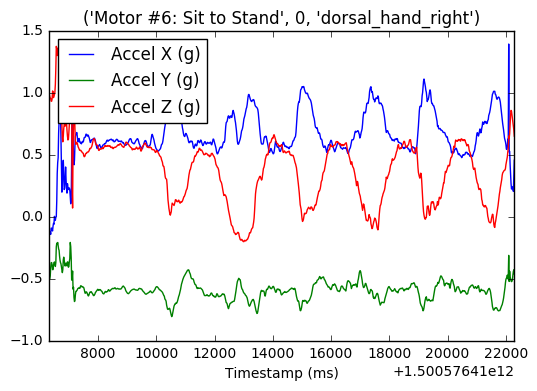

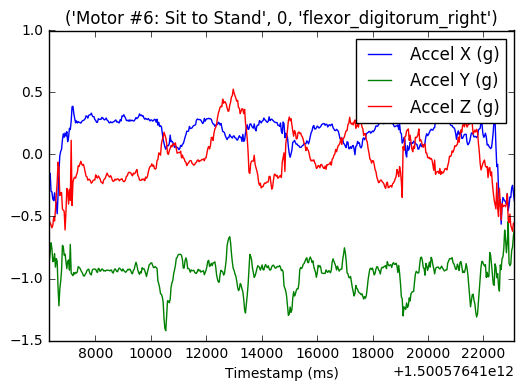

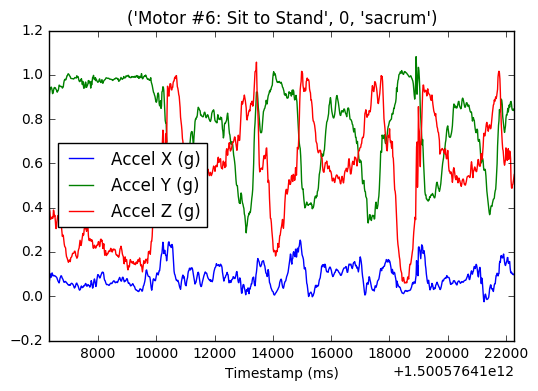

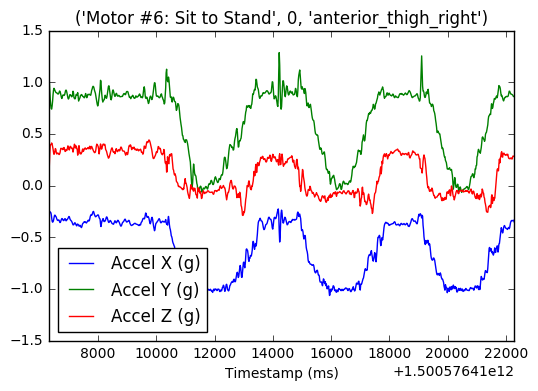

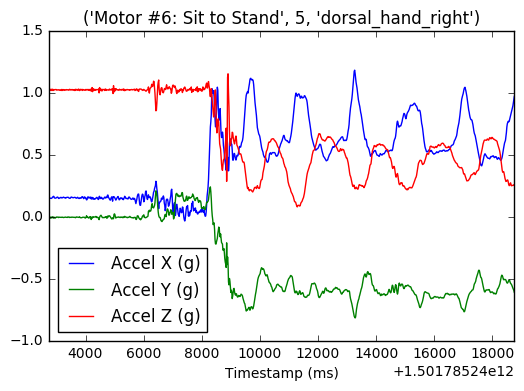

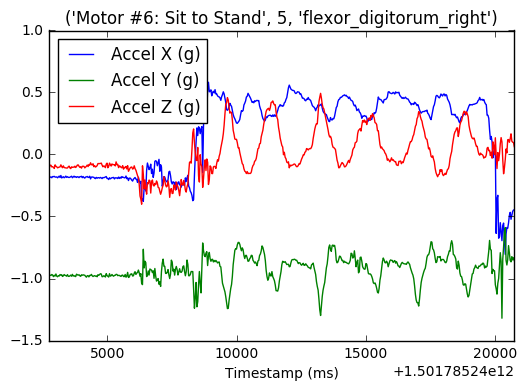

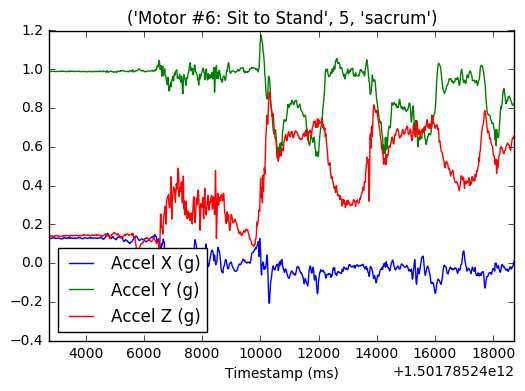

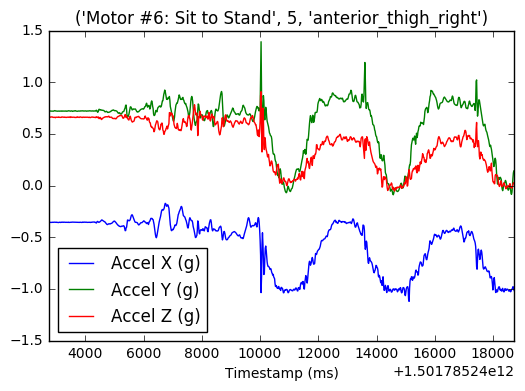

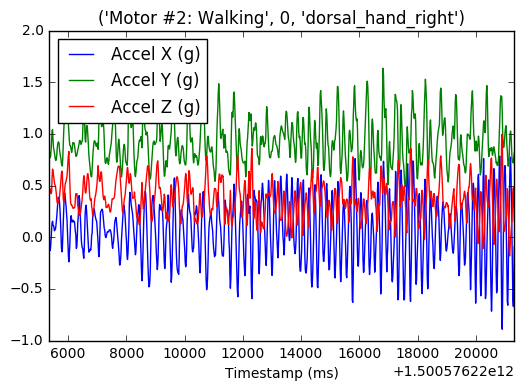

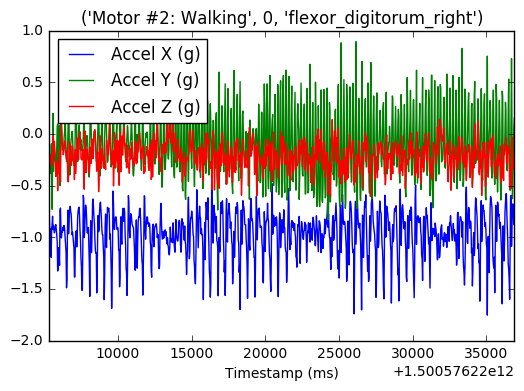

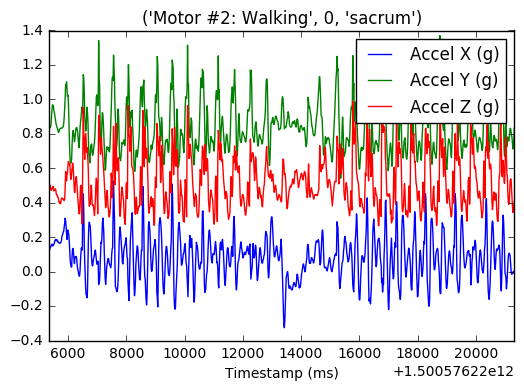

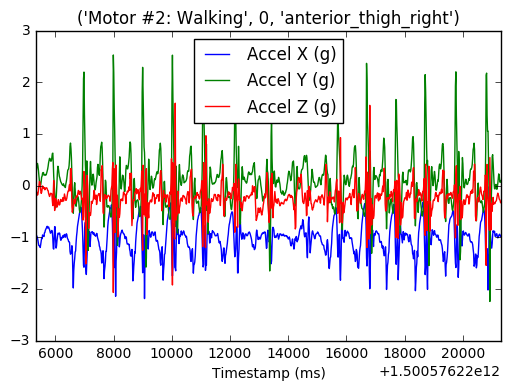

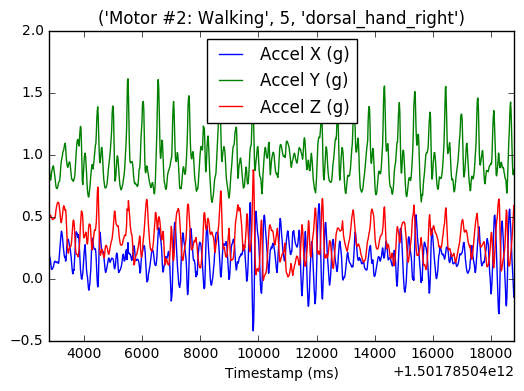

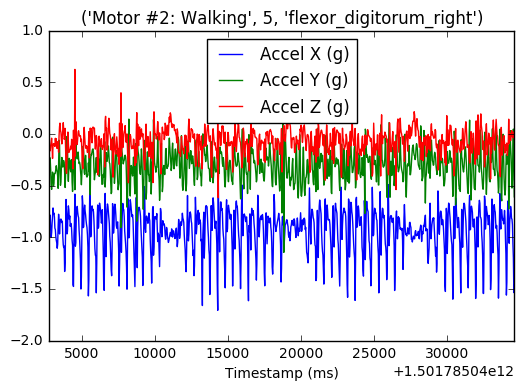

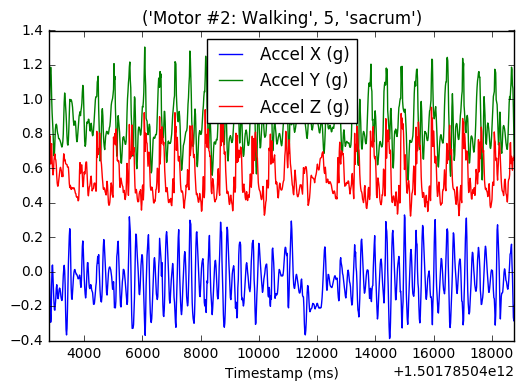

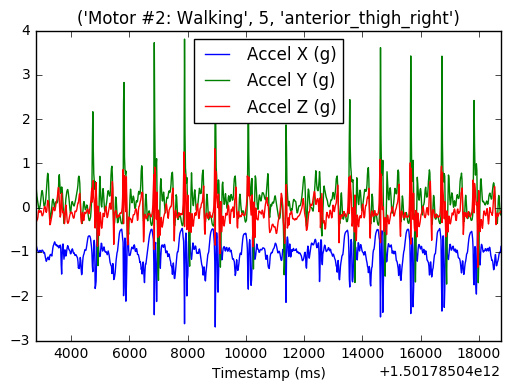

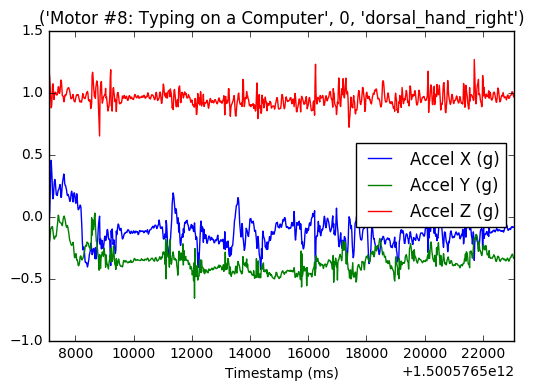

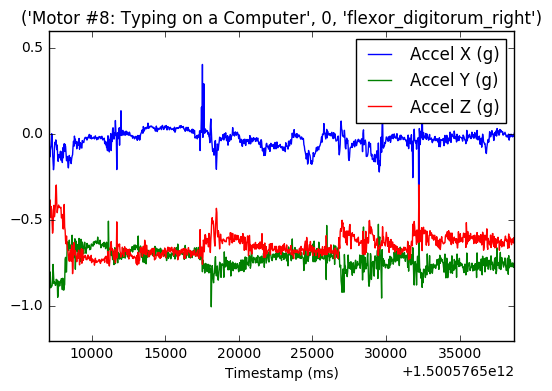

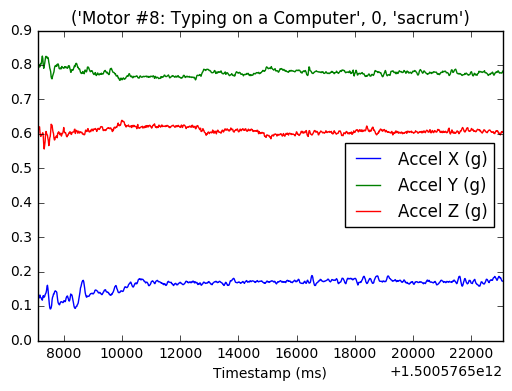

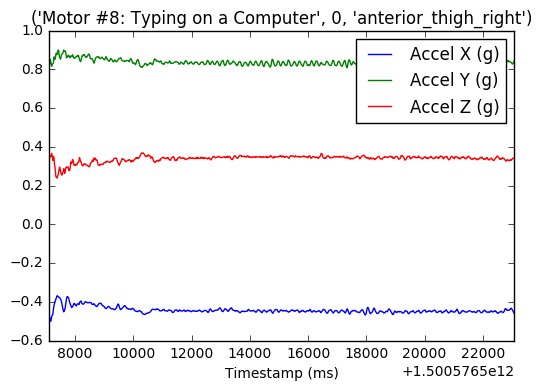

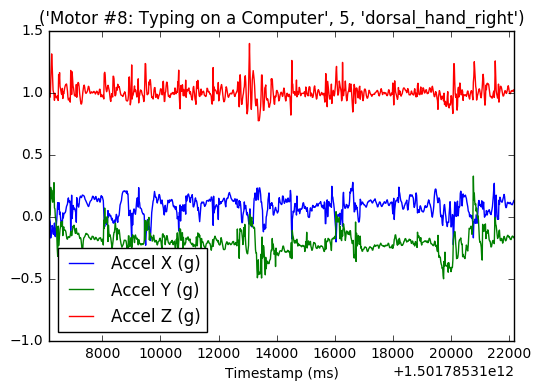

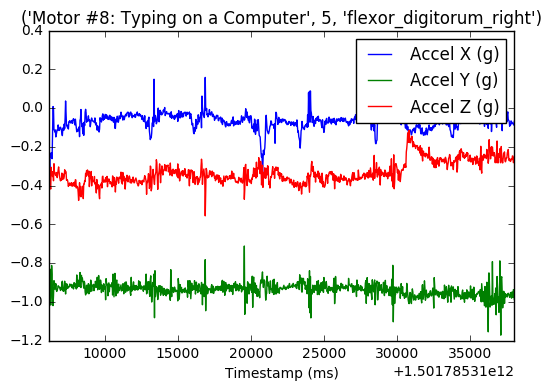

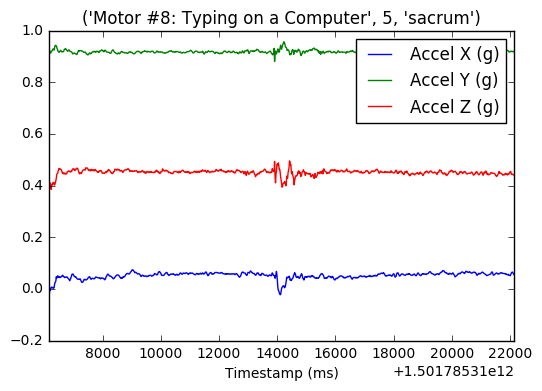

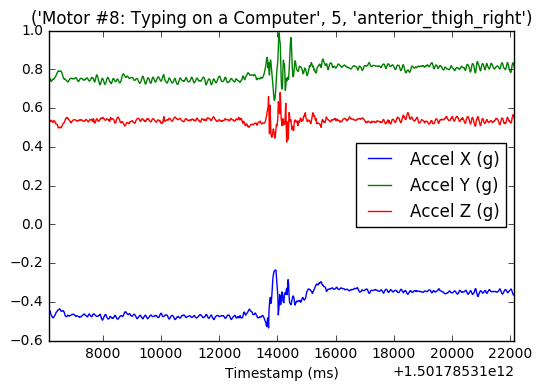

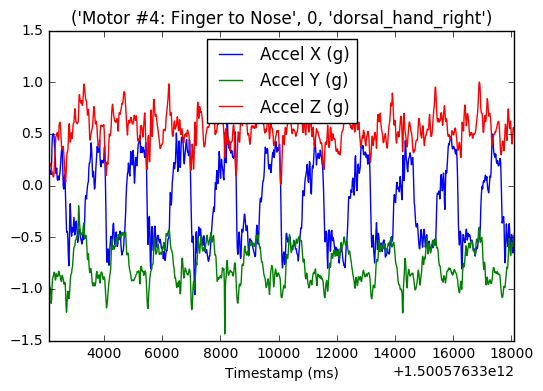

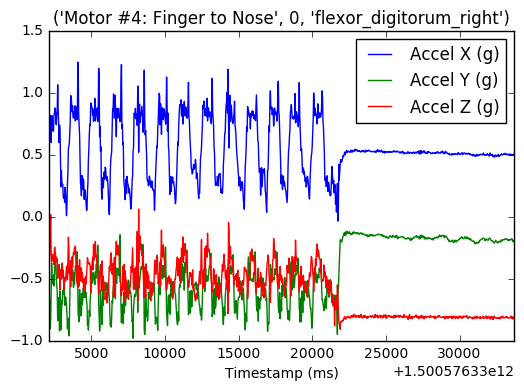

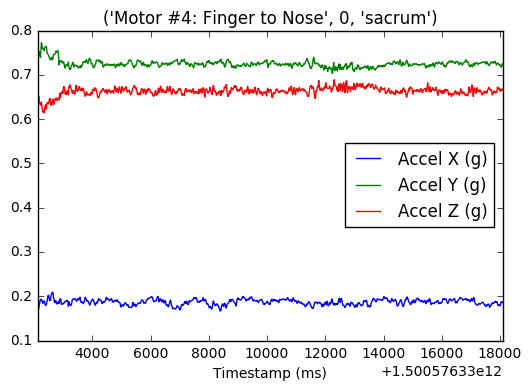

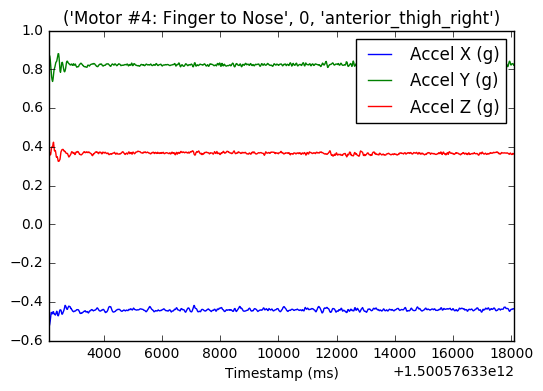

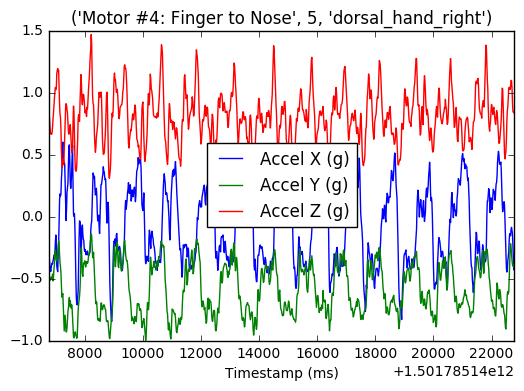

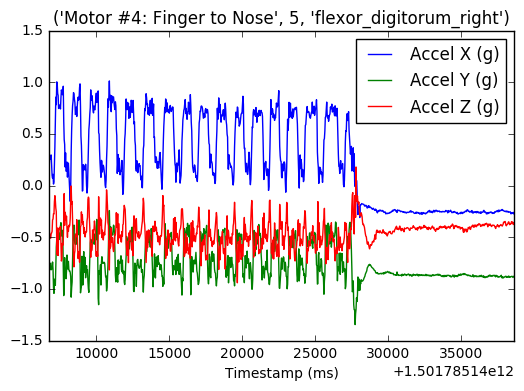

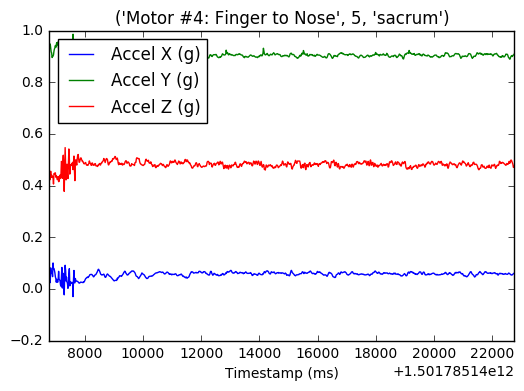

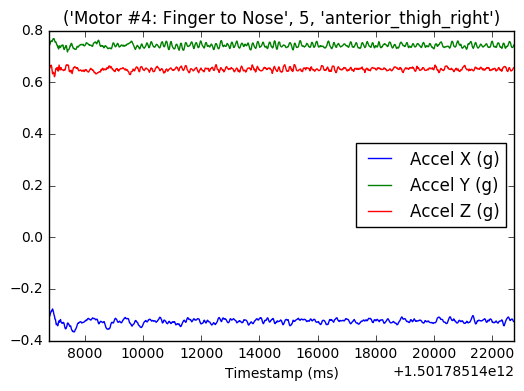

In [82]:
p = product(tasks,trials,locs)
taskslist = list(p)
for t in taskslist:
    plot_data(act_dict,t[0],t[1],t[2],'accel')
    plt.title(t)

In [83]:
#test itertools
from itertools import product
t = ('T1','T2')
l = (1,2)
s = ('s1','s2')
# print(list(product(t,l,s)))
taskslist = list(product(t,l,s))
for t in taskslist:
    print(t)

('T1', 1, 's1')
('T1', 1, 's2')
('T1', 2, 's1')
('T1', 2, 's2')
('T2', 1, 's1')
('T2', 1, 's2')
('T2', 2, 's1')
('T2', 2, 's2')


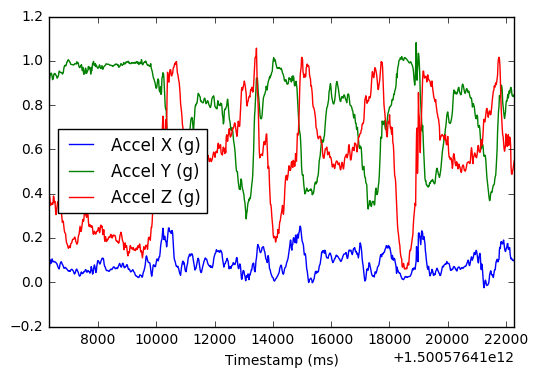

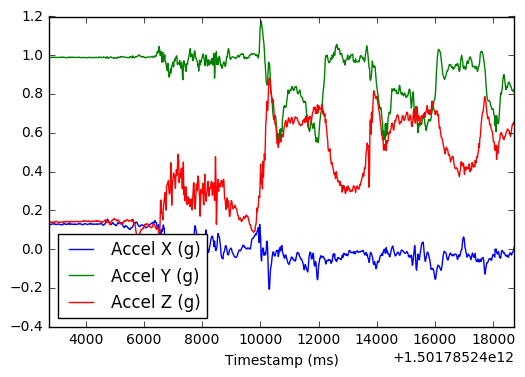

In [59]:
plot_data(act_dict,'Motor #6: Sit to Stand',0,'sacrum','accel')
plot_data(act_dict,'Motor #6: Sit to Stand',5,'sacrum','accel')
# plot_data(act_dict,'Motor #6: Sit to Stand',0,'anterior_thigh_left','accel')
# plot_data(act_dict,'Motor #6: Sit to Stand',5,'anterior_thigh_left','accel')
# plot_data(act_dict,'Motor #6: Sit to Stand',0,'flexor_digitorum_right','accel')
# plot_data(act_dict,'Motor #6: Sit to Stand',5,'flexor_digitorum_right','accel')


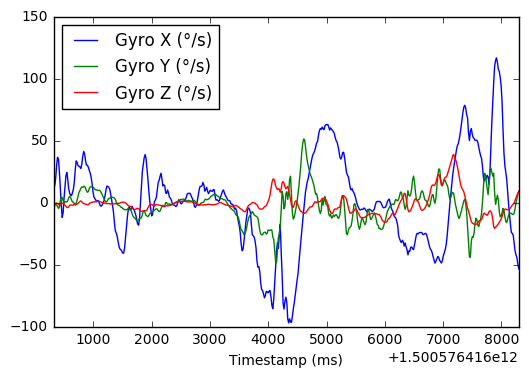

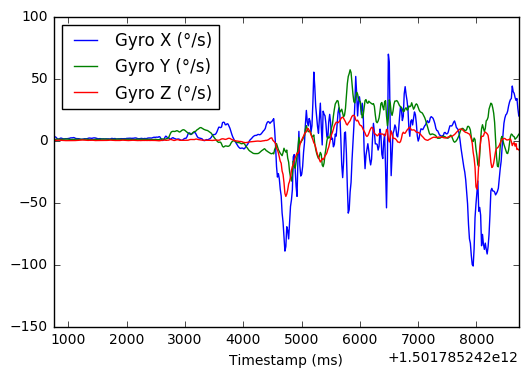

In [41]:
plot_data(act_dict,'Motor #6: Sit to Stand',0,'sacrum','gyro')
plot_data(act_dict,'Motor #6: Sit to Stand',5,'sacrum','gyro')
# plot_data(act_dict,'Motor #6: Sit to Stand',0,'anterior_thigh_left','gyro')
# plot_data(act_dict,'Motor #6: Sit to Stand',5,'anterior_thigh_left','gyro')
# plot_data(act_dict,'Motor #6: Sit to Stand',0,'flexor_digitorum_right','gyro')
# plot_data(act_dict,'Motor #6: Sit to Stand',5,'flexor_digitorum_right','gyro')

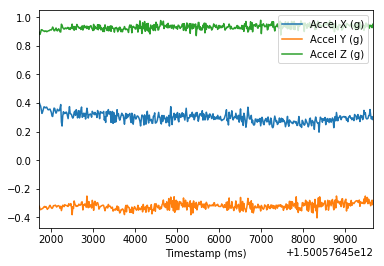

In [5]:
# Subject 1020 - OFF
plot_data(act_dict, 'Motor #7: Drawing on Paper', 0, 'dorsal_hand_right', 'accel')

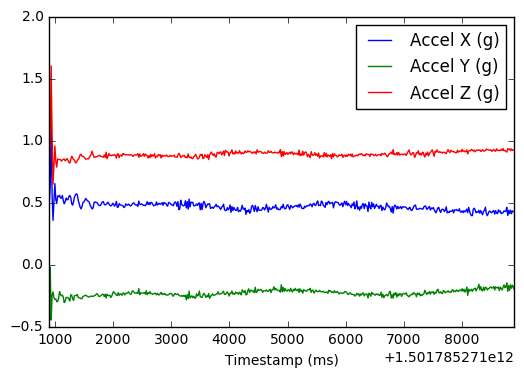

In [28]:
# Subject 1020 - ON
plot_data(act_dict, 'Motor #7: Drawing on Paper', 5, 'dorsal_hand_right', 'accel', 100, 600)

In [7]:
SubID2 = '1029'

act_dict2, timestamps2, testInfo2 = extract_data(SubID2, os.path.join(path, SubID2))

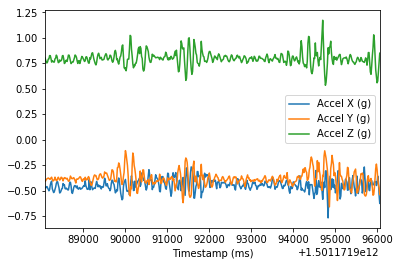

In [8]:
# Subject 1029 - OFF
plot_data(act_dict2, 'Motor #8: Typing on a Computer', 0, 'dorsal_hand_right', 'accel')

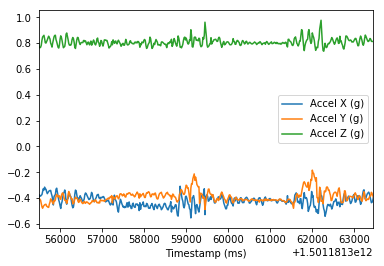

In [9]:
# Subject 1029 - ON
plot_data(act_dict2, 'Motor #8: Typing on a Computer', 5, 'dorsal_hand_right', 'accel')

In [10]:
timestamps2

,Start Timestamp (ms),Stop Timestamp (ms),Cycle
EventType,,,
Heart Rate Variability,1501170484563,1501170844573,NaN
MDS-UPDRS #1: Finger Tapping,1501171123731,1501171140862,1
MDS-UPDRS #2: Hand Movements,1501171146588,1501171157955,1
MDS-UPDRS #3: Pronation-Supination,1501171160513,1501171169220,1
MDS-UPDRS #4: Toe Tapping,1501171171984,1501171186118,1
MDS-UPDRS #5: Leg Agility,1501171188903,1501171201086,1
MDS-UPDRS #6: Arising from Chair,1501171203594,1501171210651,1
MDS-UPDRS #7: Gait,1501171219129,1501171233768,1
MDS-UPDRS #8: Postural Stability,1501171238865,1501171245703,1


In [11]:
testInfo2

,Date,Day
0,2017-07-27,DAY 1
1,2017-08-09,DAY 2


In [12]:
def fix_errors(df, SubID, path):
#def fix_errors(df, testInfo, SubID, path):
    errors = pd.read_excel(os.path.join(path, 'PD_errorWorkbook.xlsx'), sheetname='Errors',
                          converters={'Cycle':int, 'Time Adjusted (sec)':int}).set_index('Participant').loc[int(SubID)]
    
    """# Fixes absent timestamps
    if not errors.loc[errors['Error'] == 'Absent'].empty:
        df = fix_absent(df, errors.loc[errors['Error'] == 'Absent'], testInfo)
    
    # Merges two separated timestamps
    if not errors.loc[errors['Error'] == 'Merge'].empty:
        df = fix_merge(df, errors.loc[errors['Error'] == 'Merge'], testInfo)
    
    # Splits merged timestamp
    if not errors.loc[errors['Error'] == 'Split'].empty:
        df = fix_split(df, errors.loc[errors['Error'] == 'Split'], testInfo)
        
    # Fixes duplicate timestamps
    if not errors.loc[errors['Error'] == 'Duplicate'].empty:
        df = fix_duplicate(df, errors.loc[errors['Error'] == 'Duplicate'], testInfo)
        
    # Fixes late timestamps
    if not errors.loc[errors['Error'] == 'Late'].empty:
        df = fix_late(df, errors.loc[errors['Error'] == 'Late'], testInfo)
    
    # Fixes early timestamps
    if not errors.loc[errors['Error'] == 'Early'].empty:
        df = fix_early(df, errors.loc[errors['Error'] == 'Early'], testInfo)
    
    # Fixes sensors placed in reverse (incorrect orientation)
    if not errors.loc[errors['Error'] == 'Reverse'].empty:
        df = fix_reverse(df, errors.loc[errors['Error'] == 'Reverse'], testInfo)"""
    

    
    #return df
    return errors


def fix_absent(df, error_df, testInfo):
    Day1 = testInfo.loc[testInfo['Day'] == 'DAY 1', 'Date']
    Day2 = testInfo.loc[testInfo['Day'] == 'DAY 2', 'Date']
    
    


In [13]:
timestamps2.loc['Motor #6: Sit to Stand']

,Start Timestamp (ms),Stop Timestamp (ms),Cycle
EventType,,,
Motor #6: Sit to Stand,1501171833536,1501171886451,1
Motor #6: Sit to Stand,1501174769247,1501174790218,2
Motor #6: Sit to Stand,1501176904165,1501176919567,3
Motor #6: Sit to Stand,1501178075601,1501178090349,4
Motor #6: Sit to Stand,1501179743052,1501179756545,5
Motor #6: Sit to Stand,1501181275897,1501181293980,6
Motor #6: Sit to Stand,1502300740105,1502300759498,7


In [14]:
path3 = r'C:\Users\andre\Documents\PD Study Data'
errors = fix_errors(timestamps2, SubID2, path3)
errors

,Activity,Cycle,Error,Day,Time Adjusted (sec),Type
Participant,,,,,,
1029,Motor #6: Sit to Stand,1,Early,Day 1,20,Start
1029,Motor #13: Sitting,1,Early,Day 1,7,Start
1029,MDS-UPDRS #8: Postural Stability,2,Early,Day 1,10,Start


In [15]:
timestamps.loc['MDS-UPDRS #11: Rest Tremor']

,Start Timestamp (ms),Stop Timestamp (ms),Cycle
EventType,,,
MDS-UPDRS #11: Rest Tremor,1500575815425,1500575831066,1
MDS-UPDRS #11: Rest Tremor,1501784157062,1501784209549,2


In [16]:
errors = fix_errors(timestamps, SubID, path3)
errors

,Activity,Cycle,Error,Day,Time Adjusted (sec),Type
Participant,,,,,,
1020,Motor #9: Nuts and Bolts,1,Duplicate,Day 1,NaN,NaN
1020,MDS-UPDRS #10: Kinetic Hand Tremor,2,Late,Day 1,2,Start
1020,MDS-UPDRS #11: Rest Tremor,2,Absent,Day 1,NaN,Not tested
1020,MDS-UPDRS #7: Gait,1,Early,Day 2,5,Start
1020,Motor #5: Alternating Hand Movements,1,Late,Day 2,10,Start


In [17]:
error_df = errors.loc[errors['Error'] == 'Absent']
for i in range(0, int(error_df['Activity'].count())):
    columns = ['EventType', 'Start Timestamp (ms)', 'Stop Timestamp (ms)', 'Cycle']
    name = error_df.iloc[i]['Activity']
    cycle = error_df.iloc[i]['Cycle']
    temp_df = pd.DataFrame([name, 'NaN', 'NaN', cycle], index=columns).T.set_index('EventType')
    timestamps = timestamps.append(temp_df)
timestamps

,Start Timestamp (ms),Stop Timestamp (ms),Cycle
EventType,,,
Heart Rate Variability,1500574488326,1500574848328,NaN
MDS-UPDRS #11: Rest Tremor,1500575815425,1500575831066,1
MDS-UPDRS #9: Postural Hand Tremor,1500575837851,1500575842796,1
MDS-UPDRS #10: Kinetic Hand Tremor,1500575845201,1500575850709,1
MDS-UPDRS #1: Finger Tapping,1500575894522,1500575902444,1
MDS-UPDRS #2: Hand Movements,1500575905206,1500575912651,1
MDS-UPDRS #3: Pronation-Supination,1500575914789,1500575919707,1
MDS-UPDRS #4: Toe Tapping,1500575922755,1500575928707,1
MDS-UPDRS #5: Leg Agility,1500575931011,1500575936588,1


In [18]:
timestamps.loc['MDS-UPDRS #11: Rest Tremor']

,Start Timestamp (ms),Stop Timestamp (ms),Cycle
EventType,,,
MDS-UPDRS #11: Rest Tremor,1500575815425,1500575831066,1
MDS-UPDRS #11: Rest Tremor,1501784157062,1501784209549,2
MDS-UPDRS #11: Rest Tremor,NaN,NaN,2


In [19]:
for num in range(0, int(errors['Activity'].count())):
    names = errors.iloc[num]['Activity']
    print(names)

Motor #9: Nuts and Bolts
MDS-UPDRS #10: Kinetic Hand Tremor
MDS-UPDRS #11: Rest Tremor
MDS-UPDRS #7: Gait
Motor #5: Alternating Hand Movements
